# Particle Swarm Optimisation for Knights Covering Problem

In [28]:
#necessary python library imports
import numpy as np
from collections.abc import Callable
from tqdm.auto import tqdm
import itertools
import pandas as pd

## Algorithm Implementation

### Particle Swarm Optimisation class

Fitness function is an error function, so we want to minimise it

#### Utility functions

In [29]:
def none_value_wrapper(value, default):
    if value is None:
        value = default
    return value

#features are number of fitness evaluations, fitness value, number of knights, number of covered squares.
def store_iteration_results(result_array, index, num_fitness_evals, fitness_value, solution, binary_space: bool = True, board_size = None):
    num_covered_squares = 0
    if not binary_space:
        num_covered_squares = compute_num_of_covered_squares(solution, binary_space= False, board_size=board_size)
    else:
        num_covered_squares = compute_num_of_covered_squares(solution)
    num_knights = np.sum(solution != 0)
    
    result_array[index,:] = np.array([num_fitness_evals, fitness_value, num_knights, num_covered_squares])

def compute_covered_squares(particle_position: np.ndarray, binary_space: bool = True, board_size: int = None) -> np.ndarray:
    ''' 
    Computes all covered squares given the position of a single particle. 
    Covered squares are defined as positions on the chessboard that are either occupied or attacked by a knight.
    '''
    if binary_space:
        board_size = int(np.sqrt(np.prod(particle_position.shape)))
    else:
        assert board_size is not None, "When using integer space, you have to specify the board_size parameter"
        particle_position = convert_integer_to_binary_space(particle_position, board_size)

    particle_position = particle_position.reshape((board_size, board_size))
    knight_position_indices = np.argwhere(particle_position)

    covered_positions = []
    relative_jump_positions = [
        #(x_change, y_change)
        ( 0, 0),#current position
        (-1,-2),#left top
        (+1,-2),#left bottom
        (-1,+2),#right top
        (+1,+2),#right bottom
        (-2,-1),#top left
        (-2,+1),#top right
        (+2,-1),#bottom left
        (+2,+1),#bottom right
    ]

    for relative_jump_position in relative_jump_positions:
        #calculate positions that the knights can jump to
        positions = knight_position_indices.copy()
        positions += relative_jump_position   

        #calculated positions are only valid if they are within the bounds of the chessboard     
        valid_indices = np.all((positions >= 0) & (positions < board_size), axis=1)

        #append valid positions to the list of attacked positions
        covered_positions.extend(positions[valid_indices])
    
    covered_positions = np.array(covered_positions)
    unique_positions = np.unique(covered_positions, axis=0)

    return unique_positions

def convert_integer_to_binary_space(particle_position: np.ndarray, board_size: int):
    binary_position = np.zeros(shape=board_size**2, dtype=np.uint8) #initialise board
    knight_position_indices = np.cumsum(particle_position, dtype=np.uint32) #calculate knight positions on board
    knight_position_indices = knight_position_indices - 1 #set the reference point for the first knight to -1 so that 0 always indicates an unused knight
    
    #keep only valid positions
    valid_position_indices = (knight_position_indices >= 0) & (knight_position_indices < board_size**2)
    knight_position_indices = knight_position_indices[valid_position_indices]

    binary_position[knight_position_indices] = 1 #set knights on board
    return binary_position

def convert_binary_to_integer_space(particle_position: np.ndarray, max_number_of_knights):
    knight_positions = np.argwhere(particle_position == 1).flatten()
    num_knights = knight_positions.shape[0]

    relative_positions = knight_positions.copy()
    relative_positions[1:] -= relative_positions[:-1].copy() #inverse of cumsum as per https://stackoverflow.com/questions/38666924/what-is-the-inverse-of-the-numpy-cumsum-function
    integer_positions = np.zeros(max_number_of_knights, dtype=np.uint32)

    #store integer positions in return array
    if num_knights > max_number_of_knights:
        integer_positions[:max_number_of_knights] = relative_positions[:max_number_of_knights]
    else:
        integer_positions[:num_knights] = relative_positions[:num_knights]

    integer_positions[0] = integer_positions[0] + 1 # reference point for first cell is the imaginary cell with index -1
    return integer_positions


def compute_num_of_covered_squares(particle_position: np.ndarray, binary_space: bool = True, board_size: int = None) -> int:
    return compute_covered_squares(particle_position, binary_space, board_size).shape[0]


#### Algorithm implementation

In [30]:
class PSO:
    def __init__(self, board_size: int, binary_space: bool, fitness_function: Callable[[np.ndarray], np.ndarray], 
                 penalty_function: Callable[[np.ndarray, int], np.ndarray] = (lambda *x: 0), num_particles: int = 100, c1: float = 1.0, 
                 c2: float = 1.0, inertia: float = 1.0, max_velocity: float = 4.0, min_velocity: float = -4.0, 
                 rng: np.random.Generator = np.random.default_rng(None)) -> None:
        
        #check for sensible hyperparameter selection
        assert min_velocity < max_velocity, "Max velocity has to be greater than the min velocity." 
        assert num_particles > 1, "There has to be at least one particle"
        assert c1 >= 0, "c1 has to be greater than 0"
        assert c2 >= 0, "c2 has to be greater than 0"
        assert board_size > 3, "board size has to be at least 3"

        #assign hyperparameters to object variables

        #condition on sensible inertia values as proposed in: "F. van den Bergh. An Analysis of Particle Swarm Optimizers (2002)"
        if isinstance(inertia, tuple):
            self.inertia = inertia[0]
            self.max_inertia = inertia[0]
            self.min_inertia = inertia[1]
            assert self.min_inertia >= 0 and self.inertia > self.min_inertia, "min inertia must be greater or equal to zero and less than initial inertia"
        else:
            assert inertia > c1+c2 / 2 - 1 and inertia >= 0, "Inertia must be positive and greater than (c1 + c2) / 2 -1"
            self.inertia = none_value_wrapper(inertia, default=1.0)

        self.board_size = board_size
        self.binary_space = binary_space
        self.fitness_function = fitness_function
        self.penalty_function = none_value_wrapper(penalty_function, default=(lambda *x: 0))
        self.num_particles = none_value_wrapper(num_particles, default=100)
        self.c1 = none_value_wrapper(c1, default=1.0)
        self.c2 = none_value_wrapper(c2, default=1.0)
        self.max_velocity = none_value_wrapper(max_velocity,4.0)
        self.min_velocity = none_value_wrapper(min_velocity,-4.0)
        self.rng = none_value_wrapper(rng, np.random.default_rng(None))

        #initialise particles and velocities
        self.particle_positions = self.initialise_particle_positions(self.num_particles,self.binary_space, self.board_size)
        self.particle_best_pos = self.particle_positions.copy()
        
        #set initial velocity to be in range [min_velocity, max_velocity]
        random_velocities_factors = self.rng.random(size=(self.num_particles, self.particle_positions.shape[1]))
        self.particle_velocities = random_velocities_factors * (self.max_velocity - self.min_velocity) + self.min_velocity
        
        #initialise global best
        self.particle_fitness = self.compute_penalty_fitness(self.particle_positions, 0, self.binary_space, self.board_size)
        self.particle_best_fitness = self.particle_fitness.copy()

        best_fitness = np.min(self.particle_fitness) #find best fitness value
        best_indices = np.argwhere(self.particle_fitness == best_fitness) #find all particles that have the best fitness value
        best_chosen_index = self.rng.choice(best_indices) #randomly choose one of the particles with the best fitness values

        self.global_best_location = self.particle_positions[best_chosen_index].copy()
        self.global_best_fitness = self.particle_fitness[best_chosen_index][0]
    
    def initialise_particle_positions(self, num_particles: int, binary_space: bool, board_size: int):
        initial_positions = None
        if binary_space: #for binary space
            initial_positions = self.rng.integers(low=0, high=1, endpoint=True, size=(num_particles, board_size**2))

        else: #for integer space
            #formular for maximum number of knights as described in: https://mathworld.wolfram.com/KnightsProblem.html
            max_num_of_knights = (board_size**2)/2
            if board_size % 2 == 1:
                max_num_of_knights += 0.5
            max_num_of_knights = int(max_num_of_knights)

            chess_boards = np.zeros(shape=(num_particles, board_size**2), dtype=np.uint8)
            num_knights = self.rng.integers(low=1, high=max_num_of_knights,endpoint=True, size=num_particles)
            indices = [self.rng.choice(board_size**2, size=x, replace=False) for x in num_knights]
            
            for i in range(len(indices)):
                chess_boards[i,indices[i]] = 1

            initial_positions = np.apply_along_axis(convert_binary_to_integer_space, axis=1,arr=chess_boards,max_number_of_knights=max_num_of_knights)


        return initial_positions

    def compute_penalty_fitness(self, particle_positions: np.ndarray, k: int, binary_space: bool, board_size:int):
        ''' Computes the fitness subtracted by the penalty for invalid solutions (i.e. not all squares attacked or occupied).
            The penalty function receives a parameter 'k', which indicates the current iteration number.
        '''
        if binary_space:
            return self.fitness_function(particle_positions) + self.penalty_function(particle_positions, k)
        else:
            return self.fitness_function(particle_positions, board_size) + self.penalty_function(particle_positions, k, board_size)
    
    def update_locations(self, r_sigmoid, binary_space):
        if binary_space:
            #the original algorithm was flawed in regards to the position update
            #see https://www.researchgate.net/publication/224302958_A_novel_binary_particle_swarm_optimization
            sigmoid = 1/(1 + np.exp(-self.particle_velocities))
            change_indices = r_sigmoid < sigmoid

            #dimensions in which the normalised velocity value is greater than random value change their location value from 0 to 1 or vice versa
            self.particle_positions[change_indices] = (self.particle_positions[change_indices] + 1) % 2

        else:
            #adds velocity to current position. Rounds to nearest integer and clips so that the numbers are always non-negative.
            new_positions = np.clip(np.rint(self.particle_positions + self.particle_velocities),a_min=0, a_max=self.board_size**2)
            
            new_positions_array = np.zeros(shape=self.particle_positions.shape)
            non_zero_indices = new_positions != 0

            #shifts the zeros to the end of the rows while maintaining the relative order of all the other elements in the row
            for i, row in enumerate(new_positions):
                non_zero_elements = row[non_zero_indices[i]]
                new_positions_array[i,:len(non_zero_elements)] = non_zero_elements
            
            #update particle positions array
            self.particle_positions = new_positions_array

    def optimise(self, num_fitness_evaluations):
        ''' Starts the optimisation loop. The num_iterations parameter specifies the terimination criterion as 
            the number of iterations that will be done.
        '''
        num_iterations = (num_fitness_evaluations // self.num_particles)+1

        #features are number of fitness evaluations, fitness value, number of knights, number of covered squares.
        #Only current best solutions are stored
        metric_results = np.full(shape=(num_iterations, 4), fill_value=-1, dtype=np.float64)
        stored_solutions = []

        store_iteration_results(metric_results, index=0, num_fitness_evals=0, fitness_value=self.global_best_fitness,
                                solution=self.global_best_location, binary_space=self.binary_space, board_size=self.board_size)
        stored_solutions.append(self.global_best_location if self.binary_space 
                                else convert_integer_to_binary_space(self.global_best_location,self.board_size))


        # initialise random numbers used in velocity computation
        r1 = np.empty(shape=(self.num_particles,1))
        r2 = np.empty(shape=(self.num_particles,1))
        r_sigmoid = np.empty(shape=(self.num_particles,1))

        for i in range(1, num_iterations):
            #update random numbers
            self.rng.random(size=(self.num_particles,1), out=r1)
            self.rng.random(size=(self.num_particles,1), out=r2)
            self.rng.random(size=(self.num_particles,1), out=r_sigmoid)

            # update velocities
            reduced_current_velocity = self.inertia * self.particle_velocities
            local_velocity_component = self.c1 * r1 * (self.particle_best_pos - self.particle_positions)
            global_velocity_component = self.c2 * r2 * (self.global_best_location - self.particle_positions)

            new_velocity = reduced_current_velocity + local_velocity_component + global_velocity_component
            self.particle_velocities = np.clip(new_velocity, a_max= self.max_velocity, a_min= self.min_velocity)

            # update positions of particles in place
            self.update_locations(r_sigmoid, binary_space=self.binary_space)

            #linearly decrease inertia value according to: https://ieeexplore.ieee.org/document/6089659
            if hasattr(self, 'min_inertia'):
                self.inertia = self.max_inertia - i * (self.max_inertia - self.min_inertia)/(num_iterations-1)

            # calculate fitness
            self.particle_fitness = self.compute_penalty_fitness(self.particle_positions, i, self.binary_space, self.board_size)

            # update best positions
            # local best positions
            new_best_local_fitness_indices = self.particle_fitness > self.particle_best_fitness
            self.particle_best_fitness[new_best_local_fitness_indices] = self.particle_fitness[new_best_local_fitness_indices]
            self.particle_best_pos[new_best_local_fitness_indices] = self.particle_positions[new_best_local_fitness_indices]

            # global best positions
            new_best_global_fitness = np.min(self.particle_fitness) #find best fitness value
            new_best_global_fitness_indices = np.argwhere(self.particle_fitness == new_best_global_fitness) #find all particles that have the best fitness value
            new_best_chosen_global_fitness_index = self.rng.choice(new_best_global_fitness_indices) #randomly choose one of the particles with the best fitness values

            #update best solution 
            if new_best_global_fitness < self.global_best_fitness:
                self.global_best_fitness = new_best_global_fitness
                self.global_best_location = self.particle_positions[new_best_chosen_global_fitness_index].copy()
            
            #store solution and metric values to arrays
            store_iteration_results(metric_results, index=i, num_fitness_evals=i*self.num_particles, fitness_value=self.global_best_fitness,
                                    solution=self.global_best_location, binary_space=self.binary_space, board_size=self.board_size)
            stored_solutions.append(self.global_best_location if self.binary_space else convert_integer_to_binary_space(self.global_best_location, board_size=self.board_size))
        
        return metric_results, stored_solutions



### Fitness and penalty functions

#### Fitness function implementations

In [31]:
def fitness_space_pso_paper(particle_positions: np.ndarray, board_size:int = None) -> np.ndarray:
    '''From paper Investigating binary PSO parameter influence on the knights cover problem by N. Franken and A.P. Engelbrecht (2005)'''

    if board_size is not None:
        return fitness_integer_space_pso_paper(particle_positions, board_size)
    else:
        num_covered_squares = np.apply_along_axis(compute_num_of_covered_squares, axis=1, arr = particle_positions)
        num_knights = np.sum(particle_positions, axis=1)
        total_num_squares = particle_positions.shape[1]
        num_empty_squares = total_num_squares - num_covered_squares
        
        eps = 1e-6 #to avoid zero division
        fitness = num_empty_squares + num_knights + (total_num_squares+eps)/(num_covered_squares + eps)

        return fitness

def fitness_integer_space_pso_paper(particle_positions: np.ndarray, board_size:int = None) -> np.ndarray:
    num_covered_squares = np.apply_along_axis(compute_num_of_covered_squares, axis=1, arr=particle_positions, binary_space=False, board_size=board_size)
    num_knights = np.sum((particle_positions > 0), axis=1)
    total_num_squares = board_size**2
    num_empty_squares = total_num_squares - num_covered_squares
   
    eps = 1e-6 #to avoid zero division
    
    fitness = num_empty_squares + num_knights + total_num_squares/(num_covered_squares + eps)
    return fitness

#this function works for both integer and binary search space
def fitness_simple(particle_positions: np.ndarray, board_size: int = None) -> np.ndarray:
    #binary space
    ratio_of_empty_squares = None
    if board_size is None:
        ratio_of_empty_squares = (particle_positions.shape[1] - np.apply_along_axis(compute_num_of_covered_squares, axis = 1, arr=particle_positions)) \
                              / particle_positions.shape[1]
    #integer space
    else:  
        ratio_of_empty_squares = (board_size**2 - np.apply_along_axis(compute_num_of_covered_squares, axis = 1, arr=particle_positions, binary_space=False, board_size=board_size)) \
                              / board_size**2
    
    ratio_of_empty_squares = ratio_of_empty_squares.astype(dtype=np.float64)
    return ratio_of_empty_squares

#### Penalty function implementations

In [32]:
#function wrapper that can deal with both search spaces
def penalty_function(particle_positions: np.ndarray, iteration_number: int, board_size: int = None):
    if board_size is None:
        return penalty_binary_space(particle_positions, iteration_number)
    else:
        return penalty_integer_space(particle_positions, iteration_number, board_size)


#computes penalty for conventional search space depending on the ratio of empty squares
def penalty_binary_space(particle_positions: np.ndarray, iteration_number: int):
    num_knights = np.sum((particle_positions > 0), axis=1, dtype=np.float64)
    ratio_of_knights = num_knights / particle_positions.shape[0]
    return ratio_of_knights

#computes penalty for integer search space depending on ratio of empty squares and whether the knights are positioned outside the board
def penalty_integer_space(particle_positions:np.ndarray, iteration_number: int, board_size):
    last_knight_location = np.sum(particle_positions, axis=1, dtype=np.float64)
    distance_from_last_square = last_knight_location - board_size**2
    num_knights = np.sum((particle_positions > 0), axis=1)
    ratio_of_knights = num_knights / board_size**2
    penalties = ratio_of_knights + np.sqrt(iteration_number) * np.maximum(0, distance_from_last_square**2)
    return penalties

### Random Search Algorithm class

In [33]:
class RandomSearch:
    def __init__(self, board_size: int, fitness_function: Callable[[np.ndarray], np.ndarray], 
                 penalty_function: Callable[[np.ndarray, int], np.ndarray] = (lambda *x: 0), 
                 rng: np.random.Generator = np.random.default_rng(None)):
        
        self.board_size = board_size
        self.fitness_function = fitness_function
        self.penalty_function = none_value_wrapper(penalty_function, default=(lambda *x: 0))
        self.rng = rng

        self.current_solution = self.rng.integers(low=0, high=1, endpoint=True, size=board_size**2)
        #add another dimension so that fitness functions work the same across all algorithms
        self.current_solution = self.current_solution[np.newaxis,:]
        self.best_solution = self.current_solution.copy()
        self.best_fitness = self.compute_penalty_fitness(self.best_solution, 0)[0]
        
    def compute_penalty_fitness(self, particle_positions: np.ndarray, k: int):
        ''' Computes the fitness subtracted by the penalty for invalid solutions (i.e. not all squares attacked or occupied).
            The penalty function receives a parameter 'k', which indicates the current iteration number.
        '''
        
        return self.fitness_function(particle_positions) + self.penalty_function(particle_positions, k)
        
    def optimise(self, num_iterations):
        
        #features are number of fitness evaluations, fitness value, number of knights, number of covered squares.
        #Only current best solutions are stored
        metric_results = np.full(shape=(num_iterations, 4), fill_value=-1, dtype=np.float64)
        stored_solutions = []

        store_iteration_results(metric_results, index=0, num_fitness_evals=0, fitness_value=self.best_fitness,solution=self.best_solution)
        stored_solutions.append(self.best_solution)

        for i in range(1, num_iterations):
            #select random position to be altered
            mutation_index = self.rng.integers(low=0, high=self.current_solution.shape[0])
            #set element at index position to it's binary complement
            self.current_solution[mutation_index] = (self.current_solution[mutation_index]+1) % 2 
            #compute fitness of altered solution
            fitness = self.compute_penalty_fitness(self.current_solution, i)[0]
            
            #update best solution
            if(fitness < self.best_fitness):
                self.best_solution = self.current_solution.copy()
                self.best_fitness = fitness
            
            store_iteration_results(metric_results, index=i, num_fitness_evals=i, fitness_value=self.best_fitness, solution=self.best_solution)
            stored_solutions.append(self.best_solution)
        
        return metric_results, stored_solutions

### Stochastic Hillclimb Algorithm class

In [43]:
#implements First choice stochastic hill climb as per Artificial Intelligence: A Modern Approach, Global Edition, Fourth Edition
class StochasticHillclimb:
    def __init__(self, board_size: int, fitness_function: Callable[[np.ndarray], np.ndarray], 
                 penalty_function: Callable[[np.ndarray, int], np.ndarray] = (lambda *x: 0), allowed_plateau_steps: int = 100,
                 plateau_tolerance: float = 0.1, rng: np.random.Generator = np.random.default_rng(None)):
        
        assert plateau_tolerance >= 0

        self.board_size = board_size
        self.fitness_function = fitness_function
        self.penalty_function = none_value_wrapper(penalty_function, default=(lambda *x: 0))
        self.rng = rng
        self.allowed_plateau_steps = allowed_plateau_steps
        self.plateau_tolerance = plateau_tolerance
        self.current_solution = self.rng.integers(low=0, high=1, endpoint=True, size=board_size**2)

        #add another dimension so that fitness functions work the same across all algorithms
        self.current_fitness = self.compute_penalty_fitness(self.current_solution[np.newaxis,:], 0)[0]

    def compute_penalty_fitness(self, particle_positions: np.ndarray, k: int):
        ''' Computes the fitness subtracted by the penalty for invalid solutions (i.e. not all squares attacked or occupied).
            The penalty function receives a parameter 'k', which indicates the current iteration number.
        '''
        return self.fitness_function(particle_positions) + self.penalty_function(particle_positions, k)

    def optimise(self, num_function_evals):
        num_plateau_steps = 0

        #features are number of fitness evaluations, fitness value, number of knights, number of covered squares.
        #Only current best solutions are stored
        metric_results = np.full(shape=(num_function_evals, 4), fill_value=-1, dtype=np.float64)
        stored_solutions = []

        store_iteration_results(metric_results, index=0, num_fitness_evals=0, fitness_value=self.current_fitness, solution=self.current_solution)
        stored_solutions.append(self.current_solution)

        function_eval_counter = 0
        for i in range(1,num_function_evals+1): #iteration number
            neighbour_permutation = self.rng.permutation(self.current_solution.shape[0])
            
            better_solution_found = False
            for neighbour_index in neighbour_permutation:
                neighbour_solution = self.current_solution.copy()
                neighbour_solution[neighbour_index] = (neighbour_solution[neighbour_index]+1) % 2 
                
                #add another dimension so that fitness functions work the same across all algorithms
                neighbour_fitness = self.compute_penalty_fitness(neighbour_solution[np.newaxis,:], i)[0]

                function_eval_counter+=1 #increment counter of function evals
                if(function_eval_counter > num_function_evals):
                    return metric_results, stored_solutions

                #choose first neighbour with more optimal fitness (in this case, lower fitness value as we want to minimise the function)
                # neighbour has either significantly better fitness than current solution or is within plateau tolerance
                if ((neighbour_fitness - self.current_fitness)/self.current_fitness) < self.plateau_tolerance:
                    #check if fitness is on a plateau
                    if (neighbour_fitness - self.current_fitness)/self.current_fitness >= 0:
                        num_plateau_steps += 1 #increment plateau step counter
                        
                        #cancel optimisation if maximum number of plateau steps is reached
                        if num_plateau_steps > self.allowed_plateau_steps:
                            return metric_results, stored_solutions
                        
                    else: #reset plateau step counter if fitness is reduced
                        num_plateau_steps = 0

                    self.current_solution = neighbour_solution
                    self.current_fitness = neighbour_fitness

                    store_iteration_results(metric_results, index=i, num_fitness_evals=function_eval_counter, fitness_value=self.current_fitness, solution=self.current_solution)
                    stored_solutions.append(self.current_solution)
                    better_solution_found = True
                    break
            
            # no improved solution was found among the neighbours -> peak has been reached
            if not better_solution_found:
                return metric_results, stored_solutions

        #after final iteration
        return metric_results, stored_solutions 

## Experimentation

### Utility functions

In [44]:
def increment_indices(current_indices, max_indices):
    current_indices[-1] += 1
    for i in reversed(range(len(current_indices))):
        if current_indices[i] > max_indices[i]:
            current_indices[i] = 0
            if i != 0:
                current_indices[i-1] +=1
        else:
            break
    return current_indices

def fetch_algorithm_parameters(algorithm_config, parameter_indices):
    config_value_list = list(algorithm_config.values())
    parameters = [config_value_list[parameter][parameter_index] for parameter, parameter_index in enumerate(parameter_indices)]
    
    #flatten tuples in parameter list
    flattened_parameters = []
    for element in parameters:
        if isinstance(element,tuple):
            flattened_parameters.extend(element)
        else:
            flattened_parameters.append(element)
            
    return flattened_parameters

def create_dataframe_from_results(algorithm_config, parameter_values_list, metric_results_list, 
                                  solutions_list, num_of_experiments, METRIC_FEATURE_NAMES, algorithm_name):
    #extract function names from parameter list
    for i in range(len(parameter_values_list)):
        parameter_values_list[i] = [elem.__name__ if callable(elem) else elem for elem in parameter_values_list[i]]

    #calculate the number of rows in metric_results_list that correspond to the same experiment
    num_rows_per_experiment = metric_results_list.shape[0] // num_of_experiments

    #extend parameter_values_list to have the same number of elements as metric_results_list
    parameter_values_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_rows_per_experiment) for x in parameter_values_list))

    #extract column header names from algorithm config dict
    param_column_headers = list(algorithm_config.keys())
    param_column_headers = [str.split(key,"_and_") for key in param_column_headers] #split compound keys
    param_column_headers = list(itertools.chain.from_iterable(param_column_headers))#flatten list

    #convert numpy solution arrays to strings
    solutions_list = [np.array2string(x.flatten(), max_line_width=np.inf) for x in solutions_list]

    #create dataframes for metric values, parameter values, solutions and for the metadata valid for all conducted experiments
    df_metric_values = pd.DataFrame(metric_results_list, columns= METRIC_FEATURE_NAMES)
    df_param_values = pd.DataFrame(parameter_values_list, columns = param_column_headers)

    #concatenate columns of dataframes
    df_results = pd.concat([df_param_values,df_metric_values], axis=1)
    df_results = df_results.loc[(df_metric_values!=-1).any(axis=1)] #remove unused rows
    df_results = df_results.assign(solutions=solutions_list) #append solutions

    df_results["algorithm"] = algorithm_name #append information on which search algorithm was used
    return df_results
    

### Experimentation config

In [49]:
#run configuration for particle swarm optimisation
pso_config = {
    "binary_space": [True, False],
    "fitness_function_and_penalty_function": [(fitness_space_pso_paper,None),(fitness_space_pso_paper, penalty_function),
                                              (fitness_simple, penalty_function)],
    "num_particles": [100],
    "c1_and_c2_and_inertia": [(1,1,0.90), (1,1,(0.9,0.1))], #tuple of inertia values indicates that inertia is adjusted dynamically
    "max_velocity_and_min_velocity": [(4,-4)],
}

#run configuration for random search
rs_config = {
    "fitness_function_and_penalty_function": [(fitness_space_pso_paper,None),(fitness_space_pso_paper, penalty_function)]     
}

#run configuration for stochastic hillclimb
shc_config = {
    "fitness_function_and_penalty_function": [(fitness_space_pso_paper,None),(fitness_space_pso_paper, penalty_function)],
    "allowed_plateau_steps": [200],
    "plateau_tolerance": [0.05],
}

#meta run config for all experiments
run_config = {
    "optimisation_algorithm": [StochasticHillclimb],
    "algorithm_configs":[shc_config],
    "board_sizes": [5,6,7,8,9,10],
    "runs_per_experiment": 10,
    "function_evals_per_run": 100_000,
    "rng_seed": 111
}

### Run Experiments

In [50]:
NUM_METRIC_FEATURES = 4
METRIC_FEATURE_NAMES = ["fitness_evals","fitness_values","num_knights","num_covered_squares"]

# run each optimisation algorithm
for optimiser_id, algorithm in tqdm(enumerate(run_config["optimisation_algorithm"]), 
    desc="Optimisation Algorithms", total=len(run_config["optimisation_algorithm"]), position=0, leave=False):

    algorithm_config = run_config["algorithm_configs"][optimiser_id] #fetch experiment config for the current optimisation algorithm
    rng = np.random.default_rng(run_config["rng_seed"])

    #add board_sizes from run_config as first element of current config
    extended_config = {"board_sizes":run_config["board_sizes"]} 
    extended_config.update(algorithm_config)
    algorithm_config = extended_config

    max_parameter_indices = np.array([len(x)-1 for x in algorithm_config.values()], dtype=int) #compute the maximum indices for each config parameter
    num_of_experiments = np.cumprod(max_parameter_indices + 1)[-1] #compute the number of experiments to run based on number of values in config
    current_parameter_indices = np.zeros(len(algorithm_config), dtype= int) #initialise current parameter indices to 0

    #initialise result storage. When using PSO, the list will not be completely filled 
    #because less than function_evals_per_run solutions will be provided per run. These will be removed when storing the results to the dataframe
    metric_results_list = np.full(shape=(run_config["runs_per_experiment"]*num_of_experiments*run_config["function_evals_per_run"],
                                   NUM_METRIC_FEATURES), fill_value=-1, dtype=np.float64)
    stored_solutions_list = []
    parameter_values_list = []
    
    #run all experiments
    for experiment_index in tqdm(range(num_of_experiments), desc="Experiments", position=1, leave=False):
        parameters = fetch_algorithm_parameters(algorithm_config, current_parameter_indices)
        parameter_values_list.append(parameters.copy())
        parameters.append(rng) #append random number generator to parameters
        #run all runs of the same experiment
        for run in tqdm(range(run_config["runs_per_experiment"]), desc="Runs", position=2, leave=False):
            optimiser = algorithm(*parameters) #initialise optimisation algorithm with parameters
            metric_results, stored_solutions  = optimiser.optimise(run_config["function_evals_per_run"]) #perform optimisation

            start_index = experiment_index*run_config["runs_per_experiment"]*run_config["function_evals_per_run"] \
                          +run*run_config["function_evals_per_run"]
            metric_results_list[start_index:start_index+metric_results.shape[0],:] = metric_results
            stored_solutions_list.extend(stored_solutions)

        #increment indices of the current algorithm's parameters
        current_parameter_indices = increment_indices(current_parameter_indices, max_parameter_indices)
    
    df = create_dataframe_from_results(algorithm_config, parameter_values_list, metric_results_list, stored_solutions_list, num_of_experiments,
                                       METRIC_FEATURE_NAMES, algorithm_name= algorithm.__name__)

    # save dataframe to csv file
    df.to_csv(run_config["optimisation_algorithm"][optimiser_id].__name__+"_results.csv")


Optimisation Algorithms:   0%|          | 0/1 [00:00<?, ?it/s]

Experiments:   0%|          | 0/12 [00:00<?, ?it/s]

Runs:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Result Visualisation

### Load results file

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [18]:
df_rs = pd.read_csv("RandomSearch_results.csv", low_memory=False)
df_shc = pd.read_csv("StochasticHillclimb_results.csv", low_memory=False)
df_pso = pd.read_csv("PSO_results.csv", low_memory=False)

In [19]:
df_rs["penalty_function"] = df_rs["penalty_function"].astype(str)
df_shc["penalty_function"] = df_shc["penalty_function"].astype(str)
df_pso["penalty_function"] = df_pso["penalty_function"].astype(str)

df_rs["fitness_function"] = df_rs["fitness_function"].astype(str)
df_shc["fitness_function"] = df_shc["fitness_function"].astype(str)
df_pso["fitness_function"] = df_pso["fitness_function"].astype(str)

### Utility functions

In [20]:
#minimum number of knights needed as per: https://oeis.org/A006075
min_knights_dict = {
    5:5,
    6:8,
    7:10,
    8:12,
    9:14,
    10:16
}

#adding experiment and run column. 
#I could have just added this information during the experiment execution, but I forgot, so now I must suffer.
def add_experiment_and_run_column(df, indicator_column_name, runs_per_experiment):
    '''
    indicator_column_name is the name of the parameter column whose values change after every experiment,
    i.e. the last element in the respective algorithm dict which has multiple values.
    '''

    #add experiment column
    df["experiment"] = df[indicator_column_name].shift() != df[indicator_column_name]
    df["experiment"] = df["experiment"].astype(dtype=np.uint)
    df["experiment"] = df["experiment"].cumsum()

    #add run column
    df["run"] = (df["fitness_evals"] == 0).astype(np.uint)
    df["run"] = (df["run"].cumsum() - 1) % runs_per_experiment


### Add additional information to dataframes

In [21]:
add_experiment_and_run_column(df_pso, "inertia", 10)
add_experiment_and_run_column(df_shc, "penalty_function", 10)
add_experiment_and_run_column(df_rs, "penalty_function", 10)

### First solutions over number of fitness evaluations

#### Non-optimal solutions

In [22]:
pso_solutions = df_pso.copy()
shc_solutions = df_shc.copy()
rs_solutions = df_rs.copy()
#solution found but not necessarily an optimal one, i.e. not the minimum number of knights
pso_solutions = pso_solutions.loc[pso_solutions["num_covered_squares"] == pso_solutions["board_sizes"]**2,:]
pso_bin_s = pso_solutions[pso_solutions["binary_space"] == True].copy()
pso_int_s = pso_solutions[pso_solutions["binary_space"] == False].copy()

shc_s = shc_solutions.loc[shc_solutions["num_covered_squares"] == shc_solutions["board_sizes"]**2,:]
rs_s = rs_solutions.loc[rs_solutions["num_covered_squares"] == rs_solutions["board_sizes"]**2,:]

#integer space representation found less solution
print("Solutions binary space:\n",pso_bin_s["board_sizes"].value_counts().sort_index())
print()
print("Solutions integer space:\n",pso_int_s["board_sizes"].value_counts().sort_index())
print()
print("Solutions hillclimb:\n",shc_s["board_sizes"].value_counts().sort_index())
print()
print("Solutions random search:\n",rs_s["board_sizes"].value_counts().sort_index())

Solutions binary space:
 board_sizes
5     59233
6     39559
7     35008
8     12745
9      5340
10      896
Name: count, dtype: int64

Solutions integer space:
 board_sizes
5    41589
6    16527
7     2373
8       25
Name: count, dtype: int64

Solutions hillclimb:
 board_sizes
5     1158
6      615
7      587
8     1020
9     1106
10    1146
Name: count, dtype: int64

Solutions random search:
 board_sizes
5     500002
6     500000
7     200001
8     300000
9     300002
10    200004
Name: count, dtype: int64


Text(0, 0.5, 'Number of knights')

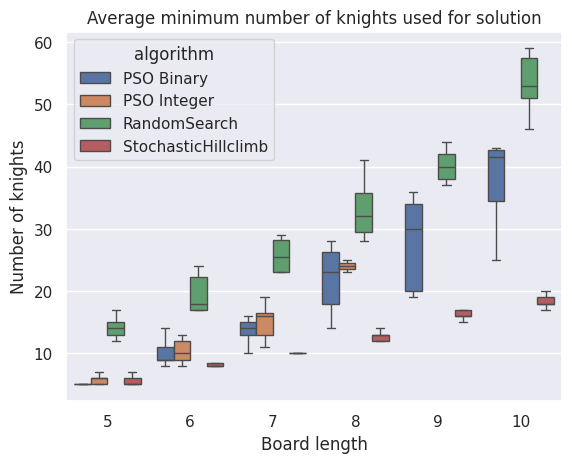

In [23]:
sns.set_theme(font_scale=1)
pso_bin_s["algorithm"] = "PSO Binary"
pso_int_s["algorithm"] = "PSO Integer"
combined_df = pd.concat([pso_bin_s, pso_int_s, shc_s, rs_s]).copy()

data =combined_df.groupby(['algorithm','board_sizes', 'experiment', 'run'])['num_knights'].min().reset_index()
ax = sns.boxplot(x='board_sizes', y='num_knights', data=data, hue='algorithm', showfliers = False)
ax.set_title("Average minimum number of knights used for solution")
ax.set_xlabel("Board length")
ax.set_ylabel("Number of knights")

In [24]:
#optimal solutions
pso_bin_opt = pso_bin_s[pso_bin_s["num_knights"] <= pso_bin_s["board_sizes"].map(min_knights_dict)].copy()
pso_int_opt = pso_int_s[pso_int_s["num_knights"] <= pso_int_s["board_sizes"].map(min_knights_dict)].copy()

shc_opt = shc_s[shc_s["num_knights"] <= shc_s["board_sizes"].map(min_knights_dict)]
rs_opt = rs_s[rs_s["num_knights"] <= rs_s["board_sizes"].map(min_knights_dict)]


#integer space representation found less optimal solutions
print("Optimal solutions binary space:\n",pso_bin_opt["board_sizes"].value_counts().sort_index())
print()
print("Optimal solutions integer space:\n",pso_int_opt["board_sizes"].value_counts().sort_index())
print()
print("Optimal solutions hillclimb:\n",shc_opt["board_sizes"].value_counts().sort_index())
print()
print("Optimal solutions random search:\n",rs_opt["board_sizes"].value_counts().sort_index())
print()

Optimal solutions binary space:
 board_sizes
5    54223
6     8146
7      876
Name: count, dtype: int64

Optimal solutions integer space:
 board_sizes
5    20765
6     4331
Name: count, dtype: int64

Optimal solutions hillclimb:
 board_sizes
5     1012
6      414
7      163
8        6
10       1
Name: count, dtype: int64

Optimal solutions random search:
 Series([], Name: count, dtype: int64)



Text(0, 0.5, 'Fitness evaluations')

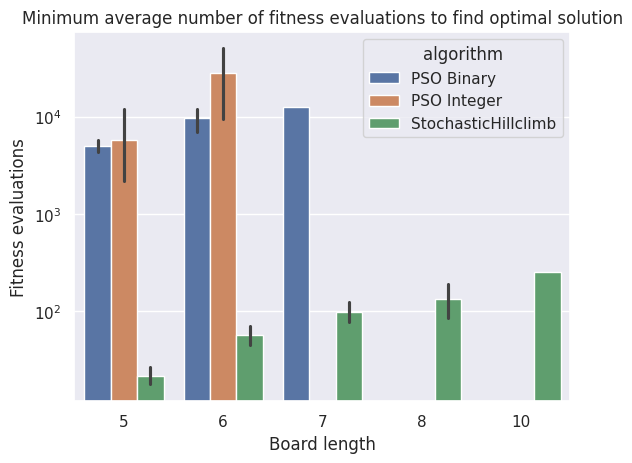

In [25]:
pso_bin_opt["algorithm"] = "PSO Binary"
pso_int_opt["algorithm"] = "PSO Integer"

combined_df = pd.concat([pso_bin_opt, pso_int_opt, shc_opt, rs_opt]).copy()

data =combined_df.groupby(['algorithm','board_sizes', 'experiment', 'run'])['fitness_evals'].min().reset_index()
ax = sns.barplot(x='board_sizes', y='fitness_evals', data=data, hue='algorithm')
ax.set_yscale("log")
ax.set_title("Minimum average number of fitness evaluations to find optimal solution")
ax.set_xlabel("Board length")
ax.set_ylabel("Fitness evaluations")

### Visualisation

Optimal solutions binary space:
 board_sizes
5    54729
6    19339
7     1117
9      891
8       43
Name: count, dtype: int64
Optimal solutions integer space:
 board_sizes
6    26945
5    26779
7    12103
8     4952
9     1372
Name: count, dtype: int64
